# Time Series Course (part 1)

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
lynx_df = pd.read_csv('datasets\lynx_data.csv')
lynx_df.head()

,year,trappings
0,1821,269
1,1822,321
2,1823,585
3,1824,871
4,1825,1475


Text(0, 0.5, '# Trappings')

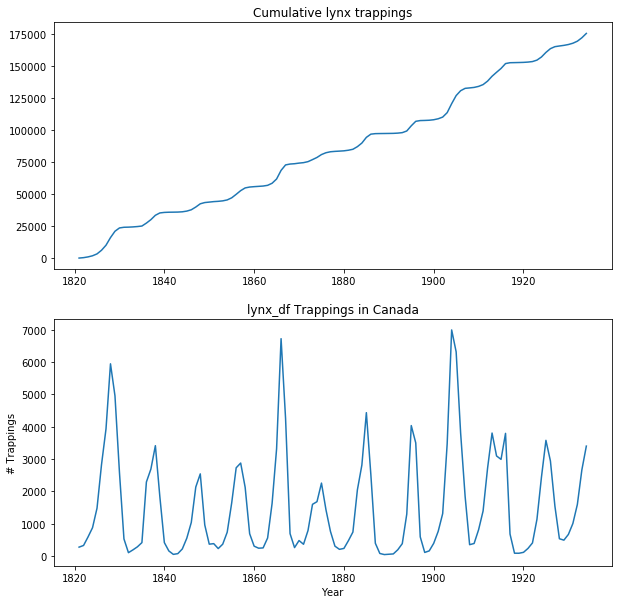

In [3]:
lynx_cumsum = np.cumsum(lynx_df['trappings'])
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(lynx_df['year'], lynx_cumsum)
plt.title("Cumulative lynx trappings")
plt.subplot(212)
plt.plot(lynx_df['year'], lynx_df['trappings'])
plt.title("lynx_df Trappings in Canada")
plt.xlabel("Year")
plt.ylabel("# Trappings")

seasonal pulses: peaks at every few years <br>
Autocorrelation: previous trapped lynx_df is an indicator of future population

#### Generate time series

In [4]:
lynx_ts = lynx_df['trappings']
print(type(lynx_ts))
lynx_ts.head()

<class 'pandas.core.series.Series'>


0     269
1     321
2     585
3     871
4    1475
Name: trappings, dtype: int64

In [5]:
lynx_ts = pd.Series(lynx_df['trappings'].values, index=pd.date_range('1821', periods=114, freq='Y'))
print(type(lynx_ts))
lynx_ts.head()

<class 'pandas.core.series.Series'>


1821-12-31     269
1822-12-31     321
1823-12-31     585
1824-12-31     871
1825-12-31    1475
Freq: A-DEC, dtype: int64

In [6]:
lynx_ts = pd.Series(lynx_df['trappings'].values, index=pd.DatetimeIndex(data = (tuple(pd.date_range('1821', periods=114, freq='Y'))), freq='Y'))
print(type(lynx_ts))
lynx_ts.head()

<class 'pandas.core.series.Series'>


1821-12-31     269
1822-12-31     321
1823-12-31     585
1824-12-31     871
1825-12-31    1475
Freq: A-DEC, dtype: int64

### Statistical characteristics of time series data
- trend - pattern
- seasonality - trend that repeats over and over
- mean - mu
- variance - sigma
- autocorrelation
- stationarity

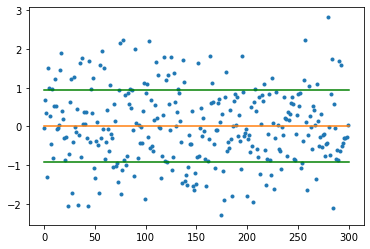

In [7]:
np.random.seed(37)
arr = np.random.randn(300)
mu = np.mean(arr)
sigma = np.var(arr)
plt.plot(arr, '.')
plt.plot([0,len(arr)], [mu, mu])
plt.plot([0,len(arr)], [sigma, sigma], 'g')
plt.plot([0,len(arr)], [-sigma, -sigma], 'g')

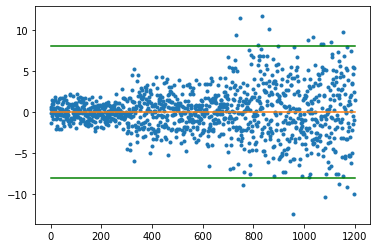

In [8]:
mu2 = 0
mu3 = 0
sigma2 = 2
sigma3 = 4
arr2 = np.random.randn(400)*sigma2 + mu2
arr3 = np.random.randn(500)*sigma3 + mu3
arrx = np.hstack([arr, arr2, arr3])
mux = np.mean(arrx)
sigmax = np.var(arrx)
plt.plot(arrx, '.')
plt.plot([0,len(arrx)], [mux, mux])
plt.plot([0,len(arrx)], [sigmax, sigmax], 'g')
plt.plot([0,len(arrx)], [-sigmax, -sigmax], 'g')

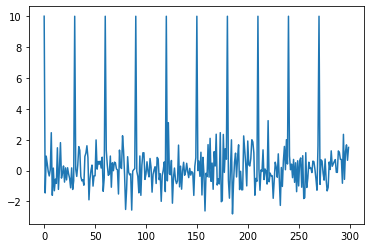

In [9]:
arrn = np.random.randn(300)
for i in range(len(arrn)):
    if i%30 == 0:
        arrn[i] = 10
        
plt.plot(arrn)

This shows seasonality

### Stationarity
- the variance, mean, and autocorrelation remain the same throughout the timeseries
- transformations and differencing can be used to impose stationarity
- data with trends and seasonality are not stationary
- https://machinelearningmastery.com/time-series-data-stationary-python/
- augmented dickey fuller test 
- https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html

In [10]:
def stationarity_test(ts):
    """
        Descr: performs augmented dickey-fuller test for stationarity
        
        Params:
            ts: timeseries data object
            
        returns: array of statistical measures indicating stationarity
    """
    from statsmodels.tsa.stattools import adfuller
    res = adfuller(ts, autolag='AIC')
    out = pd.Series(res[0:4], index=['statistic', 'p-value', '#lags', '#obs'])
    if(out['p-value'] < .05):
        res = 1
    else:
        res = 0
    return res, out

Stationarity of lynx dataset

In [11]:
res, out = stationarity_test(lynx_ts)
print(res)
print(out)

1
statistic     -2.996304
p-value        0.035241
#lags          7.000000
#obs         106.000000
dtype: float64


Stationarity of random numbers

In [12]:
mu   = 0
std  = 1
size = 300
x = np.random.normal(mu, std, size)
res,out = stationarity_test(x)
print(res)
print(out)

1
statistic   -1.702754e+01
p-value      8.370721e-30
#lags        0.000000e+00
#obs         2.990000e+02
dtype: float64


example of non stationary data

0
statistic     3.010166
p-value       1.000000
#lags         3.000000
#obs         11.000000
dtype: float64


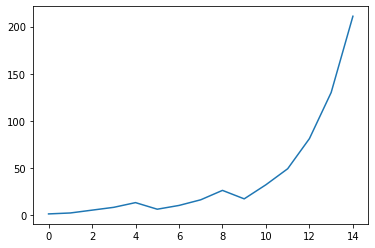

In [13]:
x = [1, 2, 5, 8, 13, 6, 10, 16, 26, 17, 32, 49, 81, 130, 211]
plt.plot(x)
res, out = stationarity_test(x)
print(res)
print(out)

### Autocorrelation
- do previous observations in a timeseries affect later observations?
- if there is a trend or seasonality, there is autocorrelation
- acf and pacf show relationship between lags and autocorrelation
- light blue is 95% confidence
- lag is time between time points, lag=n : correlation between y(t) and y(t-n)

In [14]:
def plot_autocorrelation(ts, lags):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(ts, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(ts, lags=lags, ax=ax2)

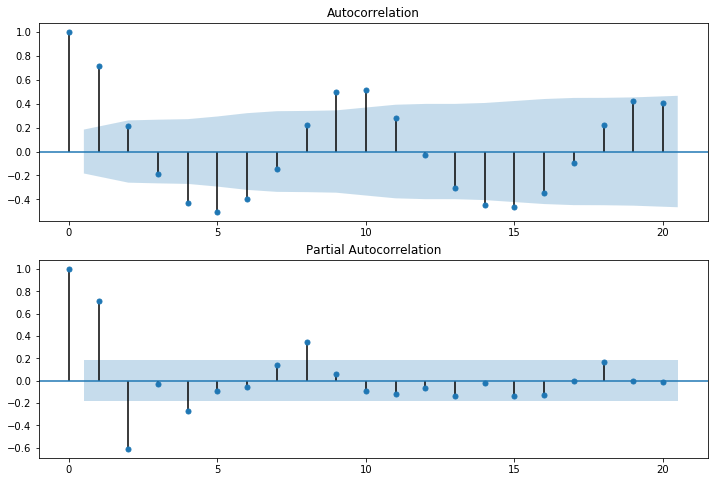

In [15]:
plot_autocorrelation(lynx_ts, 20)

exponentailly weighted moving average
- later observations are given more weight than prior observations

In [16]:
def simple_smoother(ts, window):
    """
        Descr: only works with pandas timeseries or df objects
    """
    rol_mean = ts.rolling(window).mean()
    rol_std  = ts.rolling(window).std()
    
    return rol_mean, rol_std

def ewma(ts, alpha):
    """
        Descr: only works with pandas timeseries or df objects
    """
    return ts.ewm(alpha=alpha).mean()

C:\Users\darrahts\Anaconda3\envs\tfgpu\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


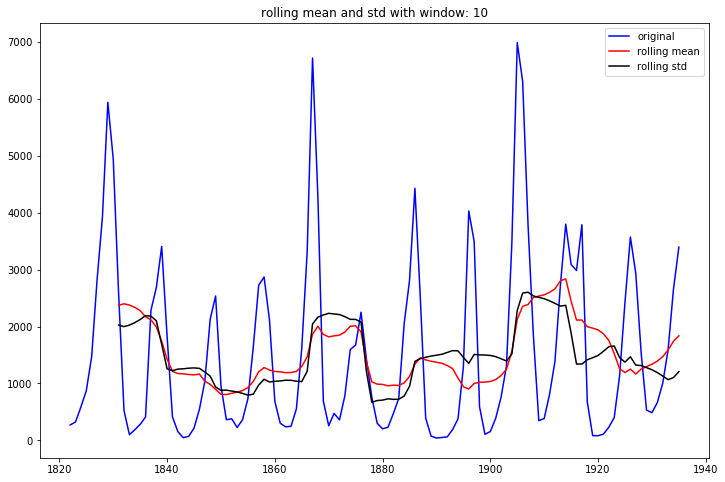

In [17]:
window = 10
rol_mean, rol_std = simple_smoother(lynx_ts, window)
fig = plt.figure(figsize=(12,8))
org = plt.plot(lynx_ts, color='blue', label='original')
mu  = plt.plot(rol_mean, color='red', label='rolling mean')
std = plt.plot(rol_std, color='black', label='rolling std')
plt.legend(loc='best')
plt.title("rolling mean and std with window: " + str(window))
plt.show()

EWMA (exonentail weighted moving average)
- 1 > alpha > 0 the deterioration of the observations
- closer to 1 just get the last observation, opposite for 0

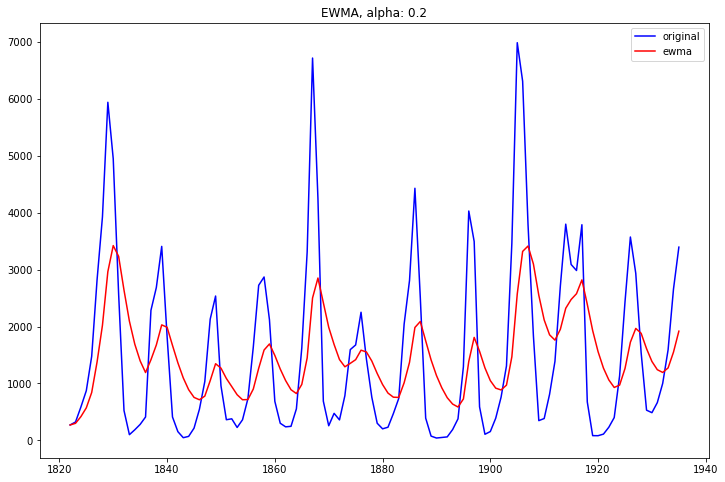

In [18]:
alpha = .2
exma = ewma(lynx_ts, alpha)
fig = plt.figure(figsize=(12,8))
org = plt.plot(lynx_ts, color='blue', label='original')
exw = plt.plot(exma, color='red', label='ewma')
plt.legend(loc='best')
plt.title("EWMA, alpha: " + str(alpha))
plt.show()

### Inflation directly / indirectly affects stocks, properties, metals, oil, etc
- month-to-month inflation rate are better than year-to-year

In [19]:
rates_df = pd.read_csv('datasets/us-infl.csv')
rates_ts = pd.Series(rates_df['x'].values, index=pd.date_range('2003', periods=180, freq='M'))
rates_ts.head()

2003-01-31    0.44
2003-02-28    0.77
2003-03-31    0.60
2003-04-30   -0.22
2003-05-31   -0.16
Freq: M, dtype: float64

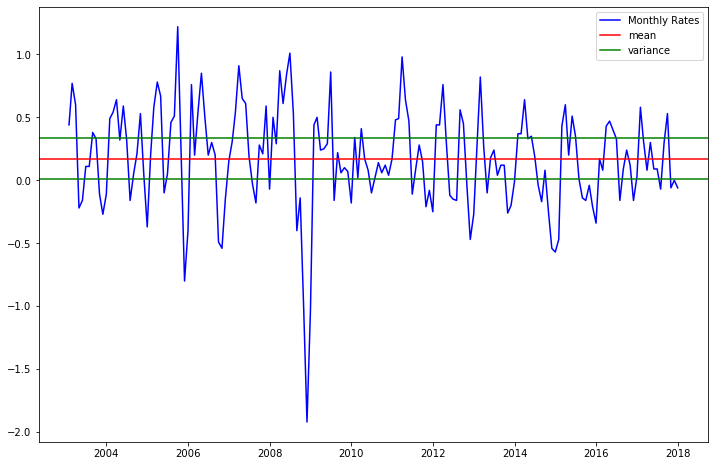

In [20]:
fig = plt.figure(figsize=(12,8))
rates = plt.plot(rates_ts, color='blue', label='Monthly Rates')
mean = np.mean(rates_ts)
var = np.var(rates_ts)
plt.axhline(y=mean, color='red', label='mean')
plt.axhline(y=(mean+var), color='green', label="variance")
plt.axhline(y=(mean-var), color='green')
plt.legend(loc='best')
plt.show()

In [21]:
res, out = stationarity_test(rates_ts)
print(res)
print(out)

1
statistic   -8.599116e+00
p-value      6.946317e-14
#lags        1.000000e+00
#obs         1.780000e+02
dtype: float64


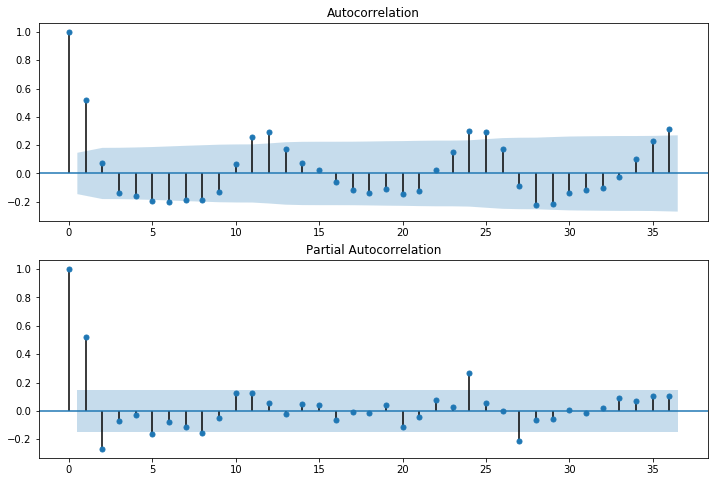

In [22]:
plot_autocorrelation(rates_ts, 36)

In [43]:
# data is already a series
temp_ts = pd.read_csv('datasets/daily-min-temperatures.csv', header=0, index_col=0)
temp_ts.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


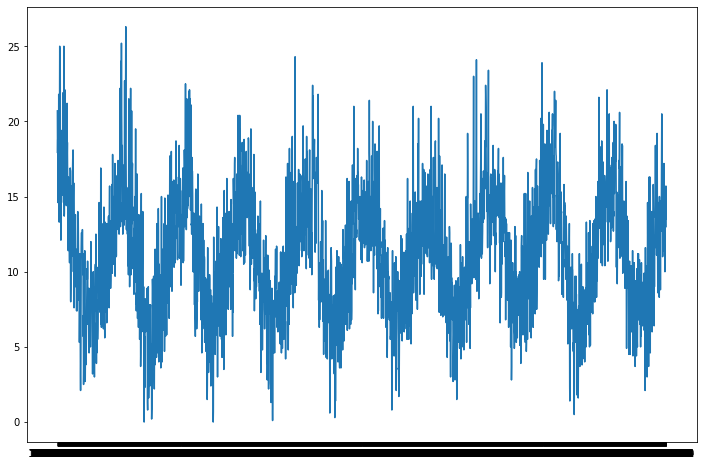

In [45]:
fig = plt.figure(figsize=(12,8))
plt.plot(temp_ts)
plt.show()

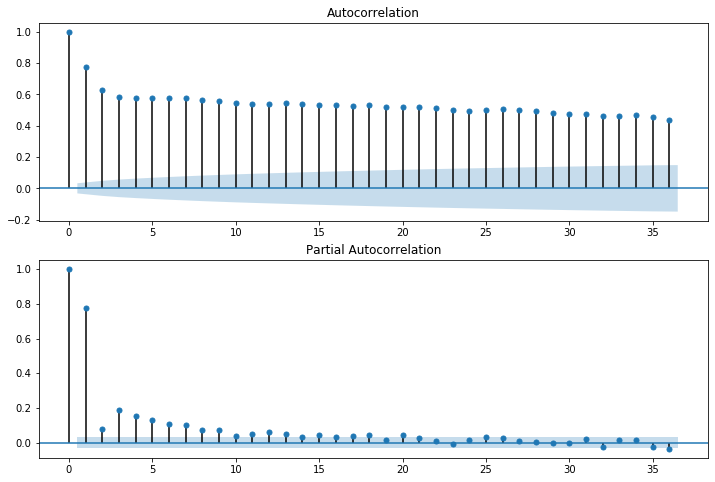

In [46]:
plot_autocorrelation(temp_ts, 36)